### Data MIning
### Decision Trees using  scikit-learn and h2o
#### Edgar Acuna
### Abril 2020

In [57]:
import h2o
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import graphviz
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import warnings
warnings.filterwarnings('ignore')
#h2o.connect()
#h2o.no_progress()
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 . connected.


H2O cluster uptime:,46 mins 49 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.27.0.4835
H2O cluster version age:,5 months and 4 days !!!
H2O cluster name:,H2O_from_python_eacun_1po7zm
H2O cluster total nodes:,1
H2O cluster free memory:,3.205 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


### I Decision Trees para Diabetes usando scikit learn

In [58]:
url= "http://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names,header=None)
#La variable de respuesta y debe ser binaria (0,1)
y=data['class']-1
X=data.iloc[:,0:8]
modeltree = tree.DecisionTreeClassifier(max_depth=3)
modeltree = modeltree.fit(X,y)

In [59]:
# Tasa de precision
modeltree.score(X, y)

0.7760416666666666

Estimating the accuracy using cross validation

In [60]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(modeltree, X, y, cv=10)
scores
#Hallando la precision media y un intervalo de confianza 
print("CV Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

CV Accuracy: 0.732 (+/- 0.078)


In [61]:
predictions = modeltree.predict(X)
print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       500
           1       0.70      0.64      0.67       268

    accuracy                           0.78       768
   macro avg       0.75      0.74      0.75       768
weighted avg       0.77      0.78      0.77       768



In [62]:
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

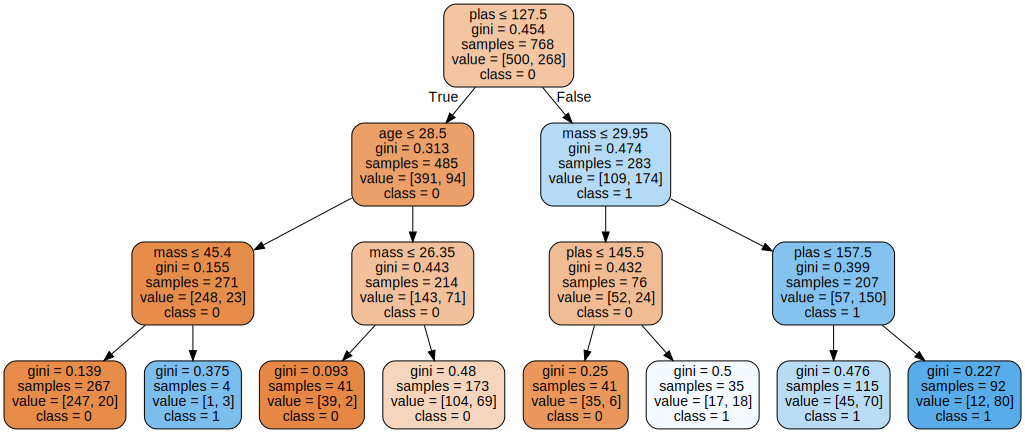

In [63]:
names=names[0:8]
clases=['0','1']
dot_data = tree.export_graphviz(modeltree, out_file=None, 
                         feature_names=names,  
                         class_names=clases,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

### Parameters to control the size of the tree

In [64]:
modeltree1 = tree.DecisionTreeClassifier(min_samples_leaf=40)
modeltree1 = modeltree1.fit(X,y)
# Tasa de precision
modeltree1.score(X, y)

0.7955729166666666

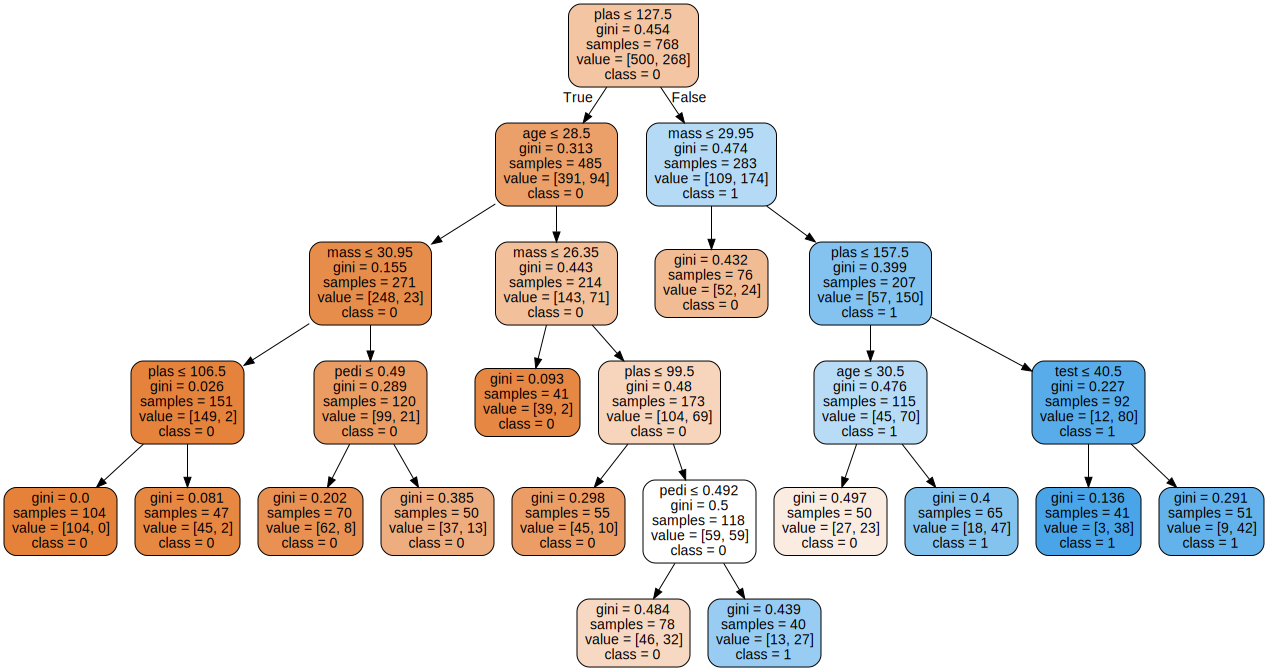

In [65]:
clases=['0','1']
dot_data = tree.export_graphviz(modeltree1, out_file=None, 
                         feature_names=names[0:8],  
                         class_names=clases,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph1= graphviz.Source(dot_data)  
graph1 

In [66]:
modeltree2 = tree.DecisionTreeClassifier(min_samples_split=100)
modeltree2 = modeltree2.fit(X,y)
# Tasa de precision
modeltree2.score(X, y)

0.8020833333333334

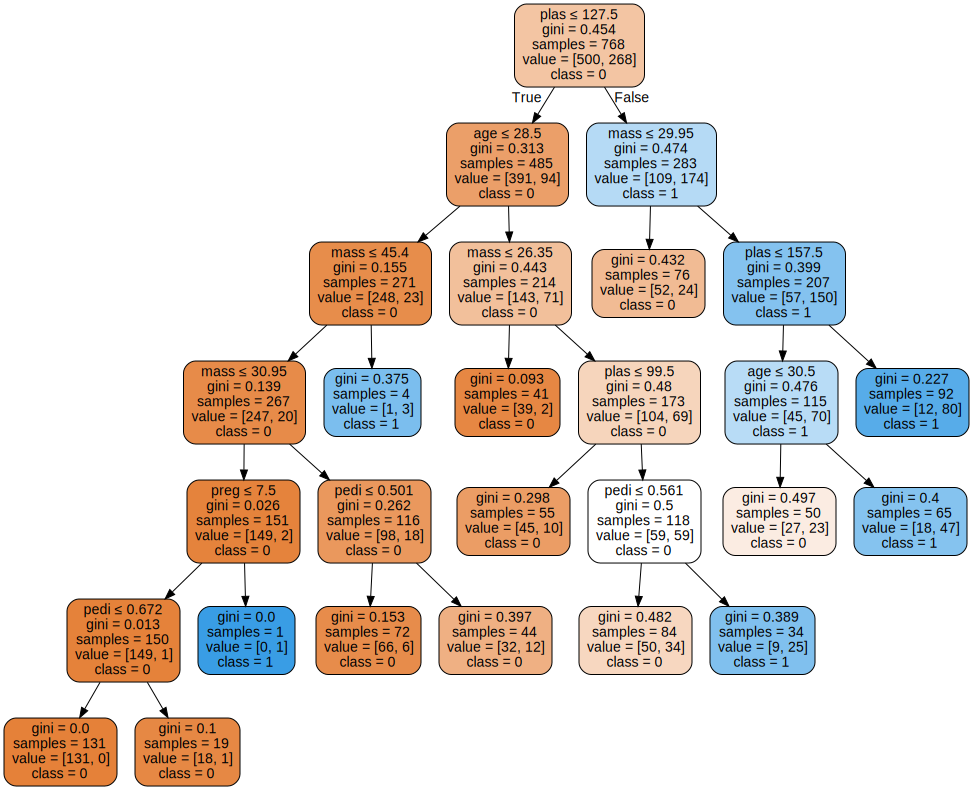

In [67]:
clases=['0','1']
dot_data = tree.export_graphviz(modeltree2, out_file=None, 
                         feature_names=names[0:8],  
                         class_names=clases,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph2= graphviz.Source(dot_data)  
graph2 

In [68]:
modeltree3 = tree.DecisionTreeClassifier(max_leaf_nodes=5)
modeltree3 = modeltree3.fit(X,y)
# Tasa de precision
modeltree3.score(X, y)

0.7721354166666666

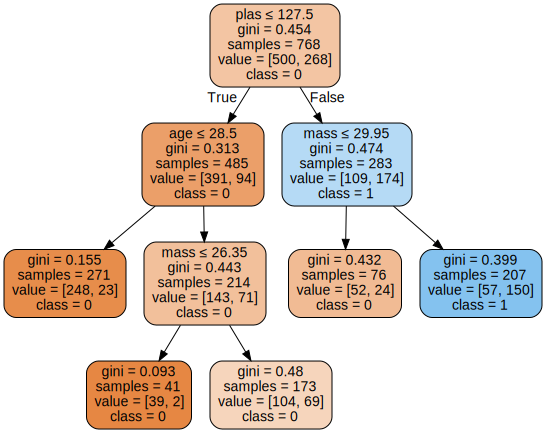

In [69]:
clases=['0','1']
dot_data = tree.export_graphviz(modeltree3, out_file=None, 
                         feature_names=names[0:8],  
                         class_names=clases,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph3= graphviz.Source(dot_data)  
graph3 

In [70]:
modeltree4 = tree.DecisionTreeClassifier(min_impurity_decrease=.001)
modeltree4 = modeltree4.fit(X,y)
# Tasa de precision
modeltree4.score(X, y)

0.9778645833333334

Estimating the accuracy by cross validation

In [71]:
scores = cross_val_score(modeltree4, X, y, cv=10)
scores
#Hallando la precision media y un intervalo de confianza 
print("CV Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

CV Accuracy: 0.720 (+/- 0.104)


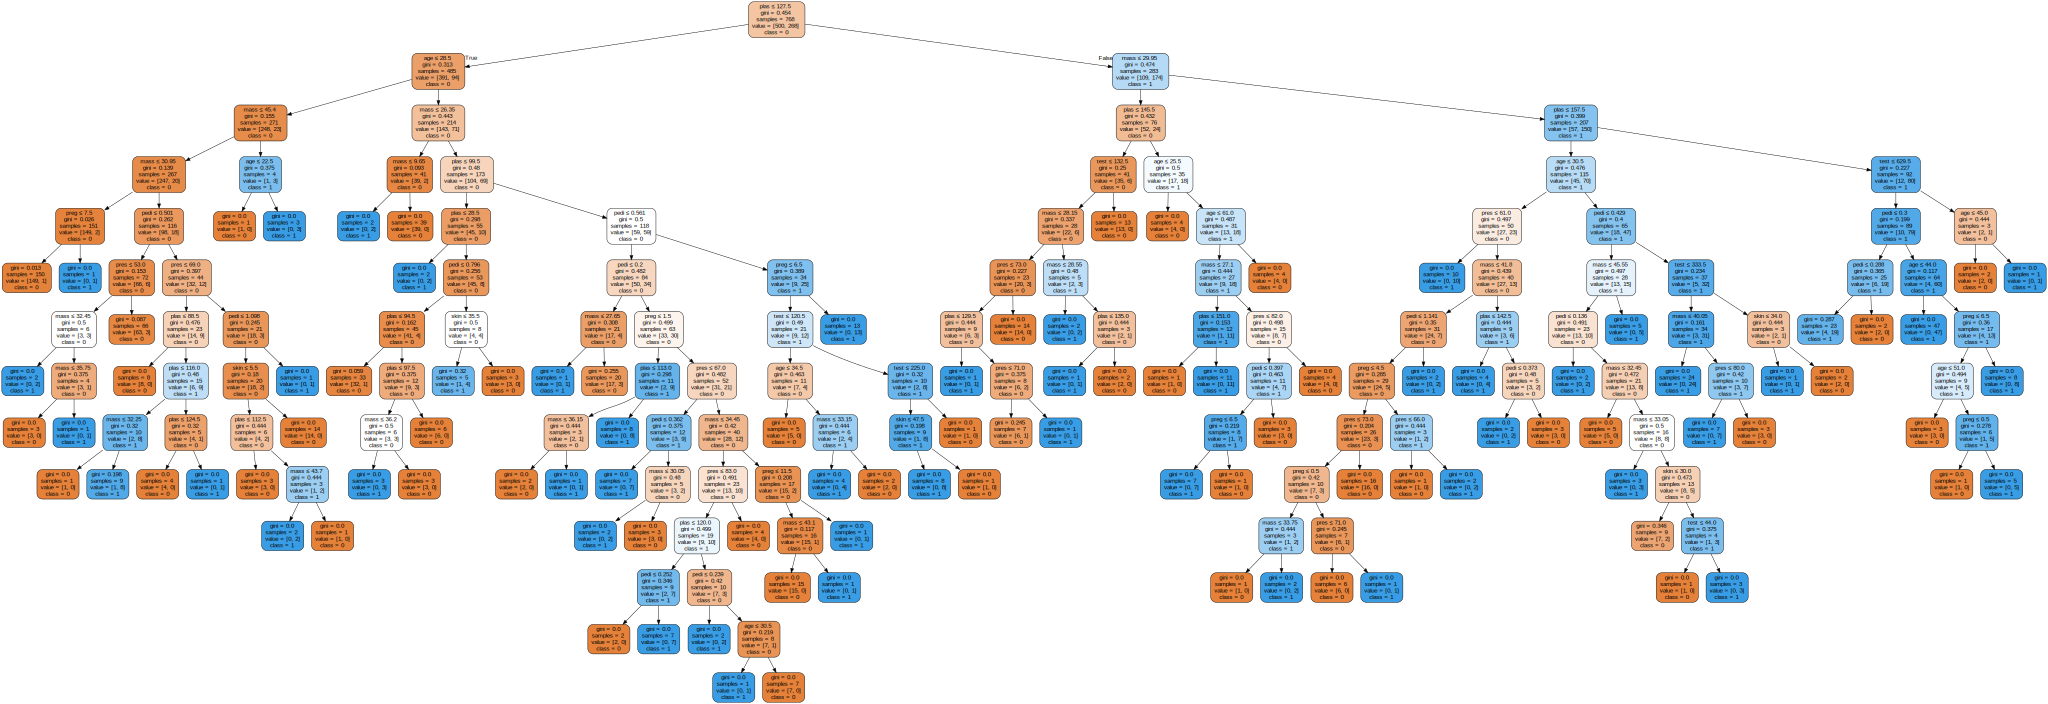

In [72]:
clases=['0','1']
dot_data = tree.export_graphviz(modeltree4, out_file=None, 
                         feature_names=names[0:8],  
                         class_names=clases,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph4= graphviz.Source(dot_data)  
graph4

### II- Applying Decision Trees  to  Diabetes using RandomForest of H20. Decision tree is a random forest with only one tree,  n=1.

In [73]:
diabetes = h2o.import_file("https://academic.uprm.edu/eacuna/diabetes.dat")
myx=['C1','C2','C3','C4','C5','C6','C7','C8']
diabetes['C9']=diabetes['C9'].asfactor()
myy="C9"
# Create test/train split
#train, test = vehicle.split_frame(ratios=[0.75], seed=1)
model=H2ORandomForestEstimator(ntrees=1,mtries=8,max_depth=3,sample_rate=1)
model.train(myx, myy, training_frame = diabetes)
model.model_performance(diabetes)

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.14864233727787834
RMSE: 0.385541615494201
LogLoss: 0.45851411549418275
Mean Per-Class Error: 0.22670149253731342
AUC: 0.835679104477612
pr_auc: 0.4741992521872623
Gini: 0.6713582089552239

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4129032492637634: 


,,1,2,Error,Rate
0,1,333.0,167.0,0.334,(167.0/500.0)
1,2,32.0,236.0,0.1194,(32.0/268.0)
2,Total,365.0,403.0,0.2591,(199.0/768.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.412903,0.703428,4.0
1,max f2,0.412903,0.800000,4.0
2,max f0point5,0.598291,0.687057,2.0
3,max accuracy,0.515152,0.776042,3.0
4,max precision,0.870968,0.870968,0.0
5,max recall,0.047619,1.000000,7.0
6,max specificity,0.870968,0.976000,0.0
7,max absolute_mcc,0.412903,0.521700,4.0
8,max min_per_class_accuracy,0.412903,0.666000,4.0
9,max mean_per_class_accuracy,0.412903,0.773299,4.0



Gains/Lift Table: Avg response rate: 34.90 %, avg score: 34.90 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.121094,0.870968,2.495908,2.495908,0.870968,0.870968,0.870968,0.870968,0.302239,0.302239,149.590756,149.590756
1,,2,0.279948,0.598291,1.738194,2.065949,0.606557,0.606557,0.720930,0.720930,0.276119,0.578358,73.819427,106.594932
2,,3,0.322917,0.515152,1.476255,1.987482,0.515152,0.515152,0.693548,0.693548,0.063433,0.641791,47.625509,98.748195
3,,4,0.524740,0.412903,1.183245,1.678160,0.412903,0.412903,0.585608,0.585608,0.238806,0.880597,18.324506,67.816007
4,,5,0.945312,0.084806,0.266161,1.049957,0.092879,0.092879,0.366391,0.366391,0.111940,0.992537,-73.383855,4.995683
5,,6,1.000000,0.047619,0.136461,1.000000,0.047619,0.047619,0.348958,0.348958,0.007463,1.000000,-86.353945,0.000000


In [74]:
y_pred=model.predict(diabetes)
acc=(y_pred['predict']==diabetes['C9']).sum()/float(len(diabetes))
print("The accuracy is:", acc)

drf prediction progress: |████████████████████████████████████████████████| 100%
The accuracy is: 0.7760416666666666


### III- Applying Decision Trees to Diabetes using Gradient Boosting of H20. Boosting is applied with a single tree 

In [75]:
gbm1 = H2OGradientBoostingEstimator(model_id="gbm_covType_v1",ntrees = 1, max_depth=3,sample_rate = 1,col_sample_rate = 1,seed=2000000
)
gbm1.train(myx, myy, training_frame=diabetes)
gbm1.model_performance(diabetes)


gbm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.21242874199296122
RMSE: 0.4608999262236448
LogLoss: 0.6145453851678104
Mean Per-Class Error: 0.23316417910447762
AUC: 0.8401044776119403
pr_auc: 0.4712824670084813
Gini: 0.6802089552238806

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35537969814699893: 


,,1,2,Error,Rate
0,1,334.0,166.0,0.332,(166.0/500.0)
1,2,36.0,232.0,0.1343,(36.0/268.0)
2,Total,370.0,398.0,0.263,(202.0/768.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.355380,0.696697,3.0
1,max f2,0.331696,0.795880,4.0
2,max f0point5,0.374286,0.681408,1.0
3,max accuracy,0.365756,0.772135,2.0
4,max precision,0.402791,0.870968,0.0
5,max recall,0.317971,1.000000,7.0
6,max specificity,0.402791,0.976000,0.0
7,max absolute_mcc,0.355380,0.509078,3.0
8,max min_per_class_accuracy,0.355380,0.668000,3.0
9,max mean_per_class_accuracy,0.355380,0.766836,3.0



Gains/Lift Table: Avg response rate: 34.90 %, avg score: 34.95 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.121094,0.402791,2.495908,2.495908,0.870968,0.402791,0.870968,0.402791,0.302239,0.302239,149.590756,149.590756
1,,2,0.273438,0.374286,1.714504,2.060554,0.598291,0.374286,0.719048,0.386910,0.261194,0.563433,71.450440,106.055437
2,,3,0.316406,0.365756,1.476255,1.981205,0.515152,0.365756,0.691358,0.384037,0.063433,0.626866,47.625509,98.120509
3,,4,0.518229,0.355380,1.183245,1.670442,0.412903,0.355380,0.582915,0.372876,0.238806,0.865672,18.324506,67.044176
4,,5,0.690104,0.331696,0.499322,1.378767,0.174242,0.331696,0.481132,0.362620,0.085821,0.951493,-50.067843,37.876654
5,,6,0.742188,0.329335,0.429851,1.312176,0.150000,0.329335,0.457895,0.360284,0.022388,0.973881,-57.014925,31.217596
6,,7,1.000000,0.317971,0.101312,1.000000,0.035354,0.318286,0.348958,0.349457,0.026119,1.000000,-89.868838,0.000000


In [76]:
y_pred=gbm1.predict(diabetes)
acc1=(y_pred['predict']==diabetes['C9']).sum()/float(len(diabetes))
print("The accuracy is:", acc1)

gbm prediction progress: |████████████████████████████████████████████████| 100%
The accuracy is: 0.7721354166666666


### IV. Decision Trees para Landsat usando scikit-learn 

In [77]:
url='http://academic.uprm.edu/eacuna/landsat.txt'
data = pd.read_table(url, header=None,delim_whitespace=True)
y=data.iloc[:,36]-1
names=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13',
            'C14','C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','C27',
           'C28','C29', 'C30','C31','C32','C33','C34','C35','C36','C37']
X=data.iloc[:,0:36]
modeltree = tree.DecisionTreeClassifier(max_depth=20)
modeltree = modeltree.fit(X,y)
# Tasa de precision
modeltree.score(X, y)
predictions = modeltree.predict(X)
print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1072
           1       1.00      1.00      1.00       479
           2       1.00      1.00      1.00       961
           3       1.00      1.00      1.00       415
           4       1.00      1.00      1.00       470
           5       1.00      1.00      1.00      1038

    accuracy                           1.00      4435
   macro avg       1.00      1.00      1.00      4435
weighted avg       1.00      1.00      1.00      4435



In [78]:
dot_data = tree.export_graphviz(modeltree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("landsat2") 

'landsat2.pdf'

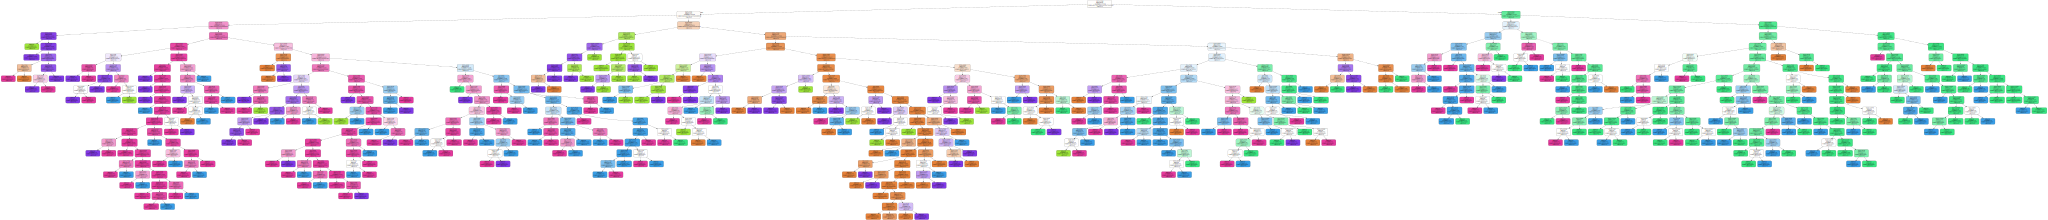

In [79]:
clases=['1',"2","3","4","5","6"]
dot1_data = tree.export_graphviz(modeltree, out_file=None, 
                         feature_names=names[0:36],
                                class_names=clases,filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot1_data)  
graph 

### V. Applying Decision trees to a dataset (adult) containing missing values (using h2o)

In [83]:
#Leyendo los datos
datos= h2o.import_file("https://academic.uprm.edu/eacuna/census.csv",na_strings=[' ?'])
myx=['age', 'employment', 'final-weight', 'education', 'education.num',
       'marital.status', 'job', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours.per.week', 'native.country']
#myx=['C1', 'C2', 'C3', 'C4', 'C5','C6','C7','C8','C9','C10','C11', 'C12','C13','C14']
datos['salary']=datos['salary'].asfactor()
myy="salary"
model=H2ORandomForestEstimator(ntrees=1,mtries=14,max_depth=3,sample_rate=1)
model.train(myx, myy, training_frame = datos)
model.model_performance(datos)

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.11339590192848084
RMSE: 0.33674308000088266
LogLoss: 0.3559405149152106
Mean Per-Class Error: 0.21962523046025184
AUC: 0.8621853033531734
pr_auc: 0.659144958338928
Gini: 0.7243706067063469

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6744805574417114: 


,,<=50K,>50K,Error,Rate
0,<=50K,23477.0,1243.0,0.0503,(1243.0/24720.0)
1,>50K,3817.0,4024.0,0.4868,(3817.0/7841.0)
2,Total,27294.0,5267.0,0.1554,(5060.0/32561.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.674481,0.613976,3.0
1,max f2,0.200000,0.750275,5.0
2,max f0point5,0.674481,0.695977,3.0
3,max accuracy,0.674481,0.844599,3.0
4,max precision,0.995575,0.995575,0.0
5,max recall,0.025577,1.000000,7.0
6,max specificity,0.995575,0.999879,0.0
7,max absolute_mcc,0.674481,0.537524,3.0
8,max min_per_class_accuracy,0.300194,0.672087,4.0
9,max mean_per_class_accuracy,0.300194,0.780375,4.0



Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.08 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.020822,0.995575,4.134285,4.134285,0.995575,0.995575,0.995575,0.995575,0.086086,0.086086,313.428450,313.428450
1,,2,0.036854,0.980843,4.073106,4.107672,0.980843,0.980843,0.989167,0.989167,0.065298,0.151384,307.310624,310.767196
2,,3,0.046467,0.974441,4.046521,4.095021,0.974441,0.974441,0.986120,0.986120,0.038898,0.190282,304.652085,309.502140
3,,4,0.161758,0.674481,2.800888,3.172641,0.674481,0.674481,0.764002,0.764002,0.322918,0.513200,180.088781,217.264101
4,,5,0.462946,0.300194,1.246602,1.919579,0.300194,0.300194,0.462253,0.462253,0.375462,0.888662,24.660226,91.957865
5,,6,0.568932,0.148868,0.618507,1.677204,0.148942,0.148942,0.403887,0.403887,0.065553,0.954215,-38.149325,67.720353
6,,7,1.000000,0.025577,0.106213,1.000000,0.025577,0.025577,0.240810,0.240810,0.045785,1.000000,-89.378707,0.000000


In [84]:
y_pred=model.predict(datos)
acc2=(y_pred['predict']==datos['salary']).sum()/float(len(datos))
print("The accuracy is:", acc2)

drf prediction progress: |████████████████████████████████████████████████| 100%
The accuracy is: 0.8445993673412979
